In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, LeakyReLU, ZeroPadding2D, BatchNormalization, concatenate, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers.legacy import Adam 
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model, Sequential

In [2]:
class GAN(object):
    def __init__(self, train_clear_path, train_noise_path, batch_size):
        '''
        :param train_clear_path: The path to clear images
        :param train_noise_path: The path to noisy images
        :param batch_size: Batch size for training
        '''
        self.clears_path = train_clear_path
        self.noises_path = train_noise_path
        self.batch_size = batch_size
        self.img_shape = (256, 256, 3)  # Define the image shape

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates an image
        input_shape = Input(shape=self.img_shape)
        generated_img = self.generator(input_shape)

        # The discriminator determines if the generated image is real or fake
        self.discriminator.trainable = False  # Freeze the discriminator for the combined model
        validity = self.discriminator(generated_img)

        # The combined model (generator and discriminator) for training
        self.combined = Model(input_shape, [generated_img, validity])
        self.combined.compile(loss=['mse', 'binary_crossentropy'],
                              loss_weights=[0.999, 0.001],
                              optimizer=optimizer)
        

    def build_generator(self):
        inputs = Input(shape=self.img_shape)

        # Contracting path (Encoder)
        conv1 = self.conv_block(inputs, 64)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

        conv2 = self.conv_block(pool1, 128)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

        conv3 = self.conv_block(pool2, 256)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

        conv4 = self.conv_block(pool3, 512)
        pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

        # Bottleneck
        bottleneck = self.conv_block(pool4, 1024)

        # Expanding path (Decoder)
        up1 = concatenate([UpSampling2D(size=(2, 2))(bottleneck), conv4])
        up1 = self.conv_block(up1, 512)

        up2 = concatenate([UpSampling2D(size=(2, 2))(up1), conv3])
        up2 = self.conv_block(up2, 256)

        up3 = concatenate([UpSampling2D(size=(2, 2))(up2), conv2])
        up3 = self.conv_block(up3, 128)

        up4 = concatenate([UpSampling2D(size=(2, 2))(up3), conv1])
        up4 = self.conv_block(up4, 64)

        output = Conv2D(3, (3, 3), activation='tanh', padding='same')(up4)

        model = Model(inputs, output)
        model.summary()

        return model

    def build_discriminator(self):
        '''
        Build the discriminator model to classify real vs. fake images
        :return: The discriminator model
        '''
        model = Sequential()
        model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.3))

        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.3))

        model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.3))

        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def conv_block(self, input_tensor, filters):
        '''
        Creates a block of two convolutional layers followed by batch normalization and activation.
        :param input_tensor: The input tensor to the block
        :param filters: The number of filters for the convolutional layers
        :return: The output tensor after applying the block
        '''
        x = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(input_tensor)
        x = BatchNormalization(momentum=0.8)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = LeakyReLU(alpha=0.2)(x)
        return x

    def load_train(self, batch_size=1):
        '''
        Load a batch of clear and noisy images from the dataset
        :param batch_size: The size of the batch to load
        :return: A batch of clear and noisy images
        '''
        clear_images = glob(f'{self.clears_path}/*')
        noisy_images = glob(f'{self.noises_path}/*')

        batch_indexes = np.random.randint(0, len(clear_images) - 1, batch_size)

        clear_batch = []
        noise_batch = []

        for idx in batch_indexes:
            clear_img = self.imread(clear_images[idx])
            noise_img = self.imread(noisy_images[idx])
            clear_batch.append(clear_img)
            noise_batch.append(noise_img)

        return np.array(clear_batch) / 127.5 - 1, np.array(noise_batch) / 127.5 - 1

    def imread(self, path):
        img = load_img(path, target_size=(256, 256))  # Resize to (256, 256)
        img_array = img_to_array(img)
        return img_array
    
    def train(self, epochs, batch_size=1, sample_interval=50):
        if not os.path.exists("models"):
            os.makedirs("models")

        # Lists to store losses and accuracy for plotting
        d_losses = []
        g_losses = []
        d_accuracies = []  # List to store discriminator accuracy

        for epoch in range(epochs):
            # Load a batch of clear and noisy images
            clear_imgs, noise_imgs = self.load_train(batch_size)

            # Generate restored images
            generated_imgs = self.generator.predict(noise_imgs)

            real_labels = np.ones((batch_size, 1))
            fake_labels = np.zeros((batch_size, 1))

            d_loss_real = self.discriminator.train_on_batch(clear_imgs, real_labels)
            d_loss_fake = self.discriminator.train_on_batch(generated_imgs, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            d_accuracies.append(100 * d_loss[1])

            g_loss = self.combined.train_on_batch(noise_imgs, [clear_imgs, real_labels])

            d_losses.append(d_loss[0])
            g_losses.append(g_loss[0])

            if epoch % sample_interval == 0:
                self.sample_images(epoch)

                self.generator.save(f"models/generator_epoch_{epoch}.keras")
                self.discriminator.save(f"models/discriminator_epoch_{epoch}.keras")

        # Save the final epoch model
        self.generator.save(f"models/generator_epoch_{epochs}.keras")
        self.discriminator.save(f"models/discriminator_epoch_{epochs}.keras")

        self.plot_losses(d_losses, g_losses, d_accuracies)

    def plot_losses(self, d_losses, g_losses, d_accuracies):
        '''
        Plot the discriminator and generator losses, and discriminator accuracy over epochs.
        :param d_losses: List of discriminator losses
        :param g_losses: List of generator losses
        :param d_accuracies: List of discriminator accuracies
        '''
        
        if not os.path.exists("samples"):
            os.makedirs("samples")

        # Plot 1: Losses
        plt.figure(figsize=(10, 5))
        plt.plot(d_losses, label="Discriminator Loss")
        plt.plot(g_losses, label="Generator Loss")
        plt.title("Training Losses")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig("samples/loss_plot.png")  
        plt.show()  
        plt.close()

        # Plot 2: Accuracy
        plt.figure(figsize=(10, 5))
        plt.plot(d_accuracies, label="Discriminator Accuracy", color="green")
        plt.title("Discriminator Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.legend()
        plt.savefig("samples/accuracy_plot.png") 
        plt.show() 
        plt.close()

    def sample_images(self, epoch):
        '''
        Save or display a batch of generated images to visualize progress.
        :param epoch: Current epoch number
        '''
        _, noise_imgs = self.load_train(batch_size=4)

        generated_imgs = self.generator.predict(noise_imgs)

        # Rescale images from [-1, 1] to [0, 1] for display
        noise_imgs = (noise_imgs + 1) / 2
        generated_imgs = (generated_imgs + 1) / 2

        plt.figure(figsize=(10, 5))
        for i in range(4):
            # Noisy Image
            plt.subplot(2, 4, i + 1)
            plt.title("Noisy")
            plt.imshow(noise_imgs[i])
            plt.axis('off')

            # Generated (Restored) Image
            plt.subplot(2, 4, i + 1 + 4)
            plt.title("Restored")
            plt.imshow(generated_imgs[i])
            plt.axis('off')

        if not os.path.exists("samples"):
            os.makedirs("samples")
        plt.savefig(f"samples/{epoch}.png")
        plt.close()

    def load_show(self, batch_size=4):
        clear_batch, noise_batch = self.load_train(batch_size)
        plt.figure(figsize=(10, 5))
        for i in range(batch_size):
            # Noisy Image
            plt.subplot(2, batch_size, i + 1)
            plt.title("Noisy")
            plt.imshow((noise_batch[i] + 1) / 2)
            plt.axis('off')

            # Clear Image
            plt.subplot(2, batch_size, i + 1 + batch_size)
            plt.title("Clear")
            plt.imshow((clear_batch[i] + 1) / 2)
            plt.axis('off')

        plt.show()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 dropout (Dropout)           (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 256)       2

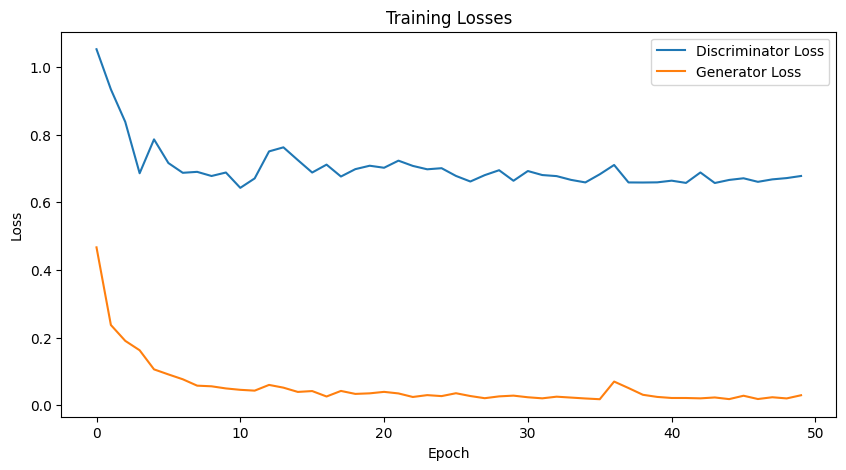

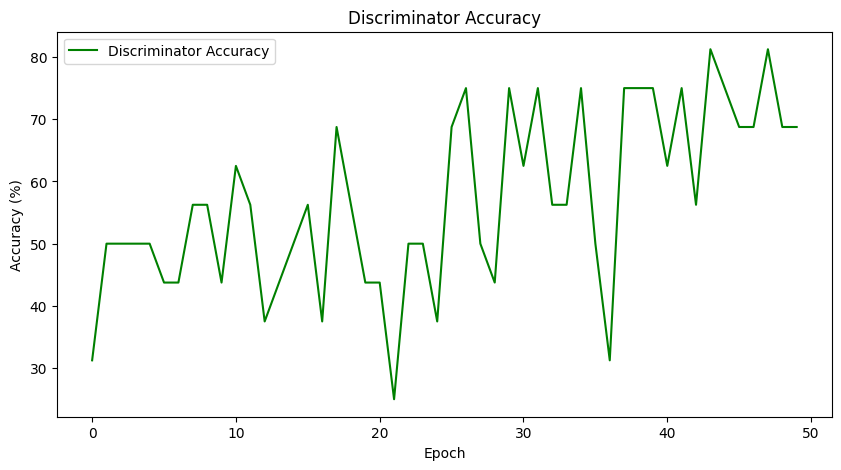

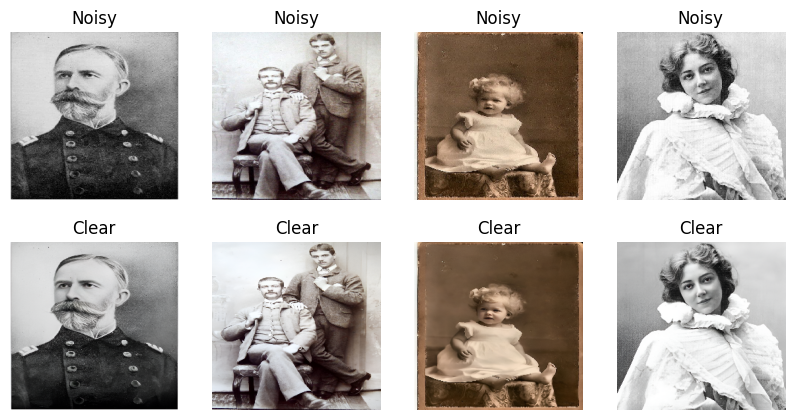

In [3]:
train_clear_path = 'demo-images/restored'
train_noise_path = 'demo-images/original'
batch_size = 8  
epochs = 50

gan = GAN(train_clear_path, train_noise_path, batch_size)

gan.train(epochs=epochs, batch_size=batch_size, sample_interval=10)

gan.load_show(batch_size=4)